# Imports

In [0]:
# imports

# Spark SQL Functions
from pyspark.sql.functions import col, when, isnan, isnull, count, regexp_replace, udf, lag, floor
from pyspark.sql.window import Window
from pyspark.sql.types import DoubleType
from pyspark.sql.functions import year, month, avg, to_date
from pyspark.sql import functions as F

# MLlib
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Spark ML Vector type (used in UDF)
from pyspark.ml.linalg import VectorUDT

# Loading the data

In [0]:
df = spark.read.csv("/FileStore/tables/Final_Merged_S_P_500_Data.csv", header=True, inferSchema=True)

df.printSchema()
df.show(5)

root
 |-- _c0: integer (nullable = true)
 |-- Date: date (nullable = true)
 |-- Price: string (nullable = true)
 |-- Open: string (nullable = true)
 |-- High: string (nullable = true)
 |-- Low: string (nullable = true)
 |-- Vol.: string (nullable = true)
 |-- Change %: string (nullable = true)

+----+----------+--------+--------+--------+--------+----+--------+
| _c0|      Date|   Price|    Open|    High|     Low|Vol.|Change %|
+----+----------+--------+--------+--------+--------+----+--------+
|4999|2000-01-03|1,455.20|1,469.20|1,478.00|1,438.40|null|  -0.95%|
|4998|2000-01-04|1,399.40|1,455.20|1,455.20|1,397.40|null|  -3.83%|
|4997|2000-01-05|1,402.10|1,399.40|1,413.30|1,377.70|null|   0.19%|
|4996|2000-01-06|1,403.50|1,402.10|1,411.90|1,392.00|null|   0.10%|
|4995|2000-01-07|1,441.50|1,403.50|1,441.50|1,400.50|null|   2.71%|
+----+----------+--------+--------+--------+--------+----+--------+
only showing top 5 rows



In [0]:
inf = spark.read.csv("/FileStore/tables/dados_inflacao_2000_2025.csv", header=True, inferSchema=True)

inf.printSchema()
inf.show(5)

root
 |-- Data: date (nullable = true)
 |-- Inflacao: double (nullable = true)

+----------+--------+
|      Data|Inflacao|
+----------+--------+
|2000-01-01|     2.7|
|2000-02-01|     3.2|
|2000-03-01|     3.8|
|2000-04-01|     3.1|
|2000-05-01|     3.2|
+----------+--------+
only showing top 5 rows



In [0]:
fut = spark.read.csv("/FileStore/tables/futuros_sp500_merged.csv", header=True, inferSchema=True)

fut.printSchema()
fut.show(5)

root
 |-- Data: date (nullable = true)
 |-- Último: string (nullable = true)
 |-- Abertura: string (nullable = true)
 |-- Alta: string (nullable = true)
 |-- Baixa: string (nullable = true)
 |-- Vol.: string (nullable = true)
 |-- Var. %: string (nullable = true)

+----------+--------+--------+--------+--------+------+------+
|      Data|  Último|Abertura|    Alta|   Baixa|  Vol.|Var. %|
+----------+--------+--------+--------+--------+------+------+
|2000-01-03|1.466,75|1.489,00|1.496,00|1.452,25|61,94K|-1,18%|
|2000-01-04|1.411,75|1.467,00|1.468,75|1.409,50|64,05K|-3,75%|
|2000-01-05|1.413,50|1.411,50|1.427,25|1.385,00|73,12K| 0,12%|
|2000-01-06|1.404,00|1.411,00|1.426,25|1.395,75|67,88K|-0,67%|
|2000-01-07|1.460,50|1.403,75|1.461,50|1.397,50|60,55K| 4,02%|
+----------+--------+--------+--------+--------+------+------+
only showing top 5 rows



# Streaming Simulation

In [0]:
# Simulate streaming over cleaned data
dates_ = df.select("Date").distinct().orderBy("Date").rdd.flatMap(lambda x: x).collect()

for d in dates_[:5]:  # first 5 days as a test
    print(f"\n Streaming batch for {d}")
    batch_df = df.filter(col("Date") == d)
    batch_df.select("Price", "Open", "High", "Low").summary("mean").show()



 Streaming batch for 2000-01-03
+-------+-----+----+----+----+
|summary|Price|Open|High| Low|
+-------+-----+----+----+----+
|   mean| null|null|null|null|
+-------+-----+----+----+----+


 Streaming batch for 2000-01-04
+-------+-----+----+----+----+
|summary|Price|Open|High| Low|
+-------+-----+----+----+----+
|   mean| null|null|null|null|
+-------+-----+----+----+----+


 Streaming batch for 2000-01-05
+-------+-----+----+----+----+
|summary|Price|Open|High| Low|
+-------+-----+----+----+----+
|   mean| null|null|null|null|
+-------+-----+----+----+----+


 Streaming batch for 2000-01-06
+-------+-----+----+----+----+
|summary|Price|Open|High| Low|
+-------+-----+----+----+----+
|   mean| null|null|null|null|
+-------+-----+----+----+----+


 Streaming batch for 2000-01-07
+-------+-----+----+----+----+
|summary|Price|Open|High| Low|
+-------+-----+----+----+----+
|   mean| null|null|null|null|
+-------+-----+----+----+----+



# Data cleaning

In [0]:
# Drop index and rename columns
df_clean = df.drop("_c0") \
    .withColumnRenamed("Vol.", "Volume") \
    .withColumnRenamed("Change %", "Change_Pct")

# Clean and convert to DoubleType
numeric_columns = ["Price", "Open", "High", "Low", "Volume", "Change_Pct"]

for col_name in numeric_columns:
    cleaned_col = regexp_replace(col(col_name), ",", "")
    if col_name == "Change_Pct":
        cleaned_col = regexp_replace(cleaned_col, "%", "")
    df_clean = df_clean.withColumn(col_name, cleaned_col.cast(DoubleType()))

# Check schema and preview
df_clean.printSchema()
df_clean.show(5)


root
 |-- Date: date (nullable = true)
 |-- Price: double (nullable = true)
 |-- Open: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Volume: double (nullable = true)
 |-- Change_Pct: double (nullable = true)

+----------+------+------+------+------+------+----------+
|      Date| Price|  Open|  High|   Low|Volume|Change_Pct|
+----------+------+------+------+------+------+----------+
|2000-01-03|1455.2|1469.2|1478.0|1438.4|  null|     -0.95|
|2000-01-04|1399.4|1455.2|1455.2|1397.4|  null|     -3.83|
|2000-01-05|1402.1|1399.4|1413.3|1377.7|  null|      0.19|
|2000-01-06|1403.5|1402.1|1411.9|1392.0|  null|       0.1|
|2000-01-07|1441.5|1403.5|1441.5|1400.5|  null|      2.71|
+----------+------+------+------+------+------+----------+
only showing top 5 rows



In [0]:
fut_clean = fut

for col_name in ["Último", "Abertura"]:
    cleaned_col = regexp_replace(col(col_name), r"\.", "")      # remove pontos 
    cleaned_col = regexp_replace(cleaned_col, ",", ".")         # troca vírgula por ponto decimal
    fut_clean = fut_clean.withColumn(col_name, cleaned_col.cast(DoubleType()))

# Selecionar e renomear colunas e guardar no novo DataFrame fut_clean
fut_clean = (
    fut_clean
    .select(
        col("Data").alias("Date"),
        col("Último").alias("FutPrice"),
        col("Abertura").alias("FutOpen")
    )
)

fut_clean.show(5)

+----------+--------+-------+
|      Date|FutPrice|FutOpen|
+----------+--------+-------+
|2000-01-03| 1466.75| 1489.0|
|2000-01-04| 1411.75| 1467.0|
|2000-01-05|  1413.5| 1411.5|
|2000-01-06|  1404.0| 1411.0|
|2000-01-07|  1460.5|1403.75|
+----------+--------+-------+
only showing top 5 rows



In [0]:
# Rename columns to English
inf = inf.select(
    F.col("Data").alias("Date"),
    F.col("Inflacao").alias("inflation")
)

# Get the minimum and maximum dates in the DataFrame
min_date, max_date = inf.select(
    F.min("Date"), F.max("Date")
).first()

# Calculate the number of days between the minimum and maximum dates
num_days = (max_date - min_date).days

# Create a DataFrame with every single day in the interval
dates_df = (
    spark.range(num_days + 1)
    .withColumn("Date", F.date_add(F.lit(min_date), F.col("id").cast("int")))
    .drop("id")
)


# Create a "YearMonth" column for joining
dates_df = dates_df.withColumn("YearMonth", F.date_format("Date", "yyyy-MM"))
inf = inf.withColumn("YearMonth", F.date_format("Date", "yyyy-MM"))

# Join daily dates to the monthly inflation values (forward fill by month)
inf_df = (
    dates_df.join(
        inf.select("YearMonth", "inflation"),
        on="YearMonth",
        how="left"
    )
    .select("Date", "inflation")
    .orderBy("Date")
)

# Show the first 5 rows
inf_df.show(5)


+----------+---------+
|      Date|inflation|
+----------+---------+
|2000-01-01|      2.7|
|2000-01-02|      2.7|
|2000-01-03|      2.7|
|2000-01-04|      2.7|
|2000-01-05|      2.7|
+----------+---------+
only showing top 5 rows



In [0]:
# Data Overview 
n_rows = df_clean.count()
n_cols = len(df_clean.columns)
print(f"Shape: ({n_rows}, {n_cols})")

print("\nSchema:")
df_clean.printSchema()

print("\nSummary statistics:")
df_clean.describe().show()


Shape: (6381, 7)

Schema:
root
 |-- Date: date (nullable = true)
 |-- Price: double (nullable = true)
 |-- Open: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Volume: double (nullable = true)
 |-- Change_Pct: double (nullable = true)


Summary statistics:
+-------+-----------------+------------------+------------------+------------------+------+--------------------+
|summary|            Price|              Open|              High|               Low|Volume|          Change_Pct|
+-------+-----------------+------------------+------------------+------------------+------+--------------------+
|  count|             6381|              6381|              6381|              6381|     0|                6381|
|   mean| 2164.53721517003| 2164.202632816173| 2176.804392728415|2150.6777589719463|  null|0.029260304027581886|
| stddev|1308.912238509066|1308.6283670615232|1315.1034378924674|1301.7344546369168|  null|   1.230067887404203|
|    min|  

In [0]:
# For fut_clean
n_rows = fut_clean.count()
n_cols = len(fut_clean.columns)
print(f"Shape of fut_clean: ({n_rows}, {n_cols})\n")

print("Schema of fut_clean:")
fut_clean.printSchema()

print("\nSummary statistics of fut_clean:")
fut_clean.describe().show()


Shape of fut_clean: (6522, 3)

Schema of fut_clean:
root
 |-- Date: date (nullable = true)
 |-- FutPrice: double (nullable = true)
 |-- FutOpen: double (nullable = true)


Summary statistics of fut_clean:
+-------+------------------+------------------+
|summary|          FutPrice|           FutOpen|
+-------+------------------+------------------+
|  count|              6522|              6522|
|   mean|2188.5250061330885|2187.6824011039566|
| stddev|1323.2849778473096|1322.6904094181505|
|    min|             676.0|            674.75|
|    max|            6163.0|           6153.75|
+-------+------------------+------------------+



In [0]:
# For inf_df
n_rows_inf = inf_df.count()
n_cols_inf = len(inf_df.columns)
print(f"\nShape of inf_df: ({n_rows_inf}, {n_cols_inf})\n")

print("Schema of inf_df:")
inf_df.printSchema()

print("\nSummary statistics of inf_df:")
inf_df.describe().show()


Shape of inf_df: (9223, 2)

Schema of inf_df:
root
 |-- Date: date (nullable = false)
 |-- inflation: double (nullable = true)


Summary statistics of inf_df:
+-------+------------------+
|summary|         inflation|
+-------+------------------+
|  count|              9223|
|   mean|2.6997397809824304|
| stddev|1.7230390359342143|
|    min|              -2.1|
|    max|               9.1|
+-------+------------------+



In [0]:
# Merging the dataset
stock_df = df_clean # storing the stock df somewhere just in case

# check for the correct column type
df_clean = df_clean.withColumn("Date", to_date("Date"))
fut_clean = fut_clean.withColumn("Date", to_date("Date"))
inf_df = inf_df.withColumn("Date", to_date("Date"))

# Join fut_clean and inf_df to clean_df, keeping only dates in clean_df (inner join)
df_clean = (
    df_clean
    .join(fut_clean, on="Date", how="left")  # or "inner" if you want to keep only matching dates in fut_clean
    .join(inf_df, on="Date", how="left")     # or "inner" if you want to keep only matching dates in inf_df
)

# Show result
df_clean.show(5)

+----------+------+------+------+------+------+----------+--------+-------+---------+
|      Date| Price|  Open|  High|   Low|Volume|Change_Pct|FutPrice|FutOpen|inflation|
+----------+------+------+------+------+------+----------+--------+-------+---------+
|2000-01-03|1455.2|1469.2|1478.0|1438.4|  null|     -0.95| 1466.75| 1489.0|      2.7|
|2000-01-04|1399.4|1455.2|1455.2|1397.4|  null|     -3.83| 1411.75| 1467.0|      2.7|
|2000-01-05|1402.1|1399.4|1413.3|1377.7|  null|      0.19|  1413.5| 1411.5|      2.7|
|2000-01-06|1403.5|1402.1|1411.9|1392.0|  null|       0.1|  1404.0| 1411.0|      2.7|
|2000-01-07|1441.5|1403.5|1441.5|1400.5|  null|      2.71|  1460.5|1403.75|      2.7|
+----------+------+------+------+------+------+----------+--------+-------+---------+
only showing top 5 rows



# EDA

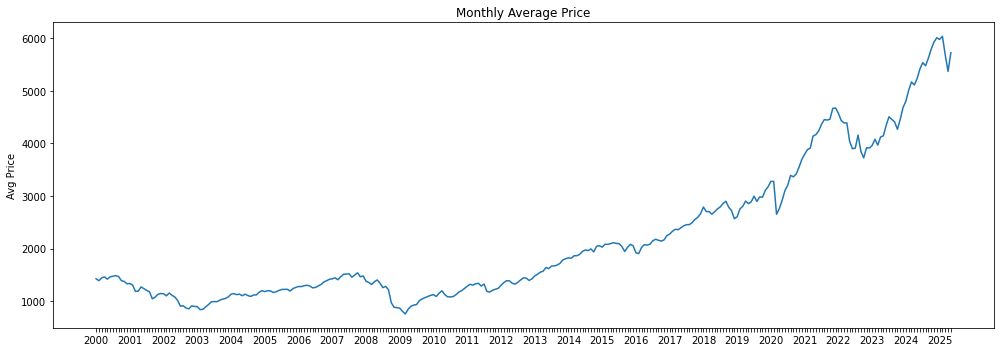

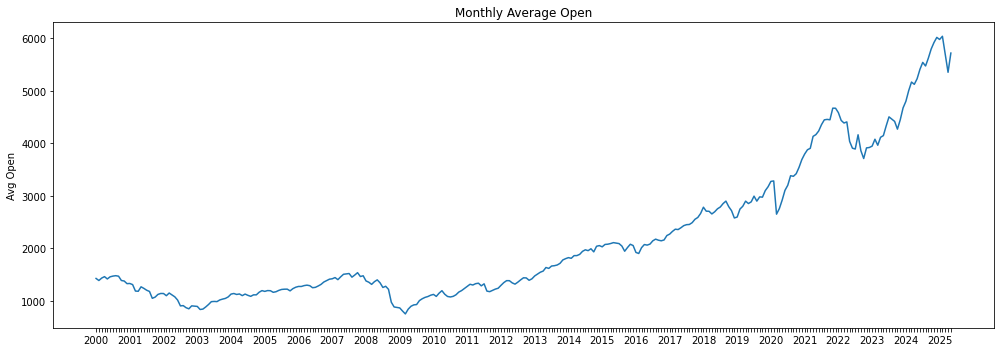

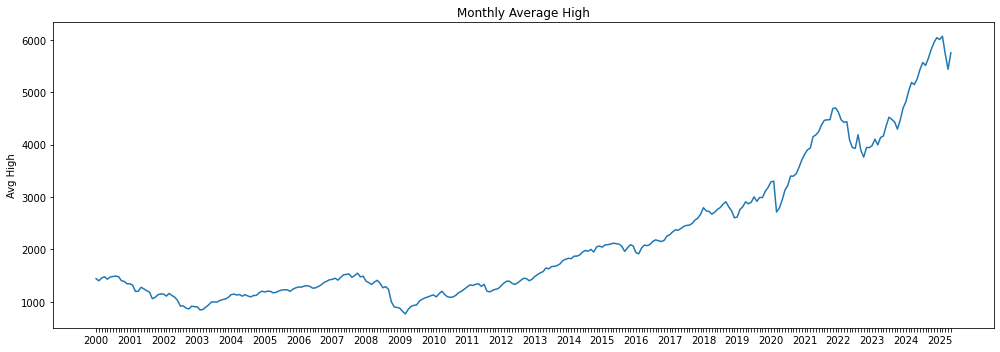

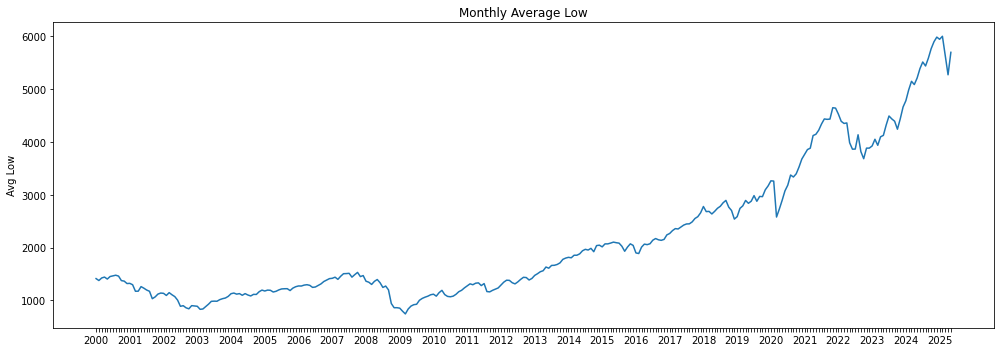

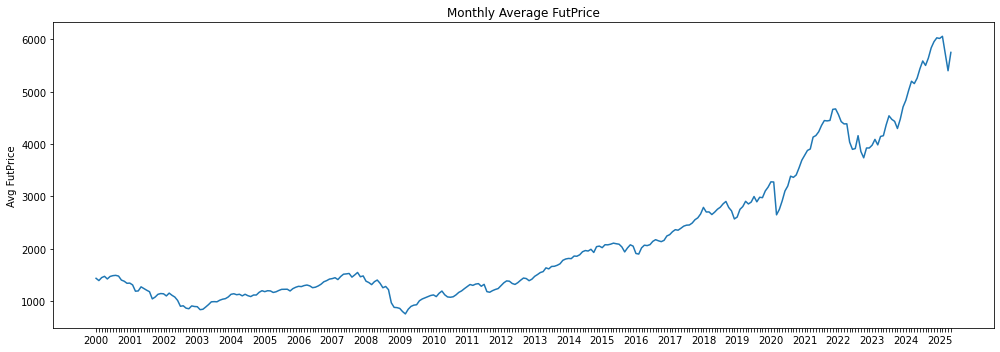

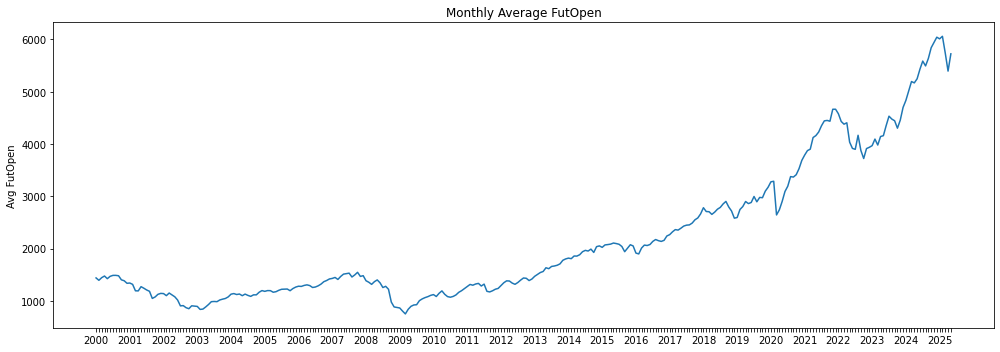

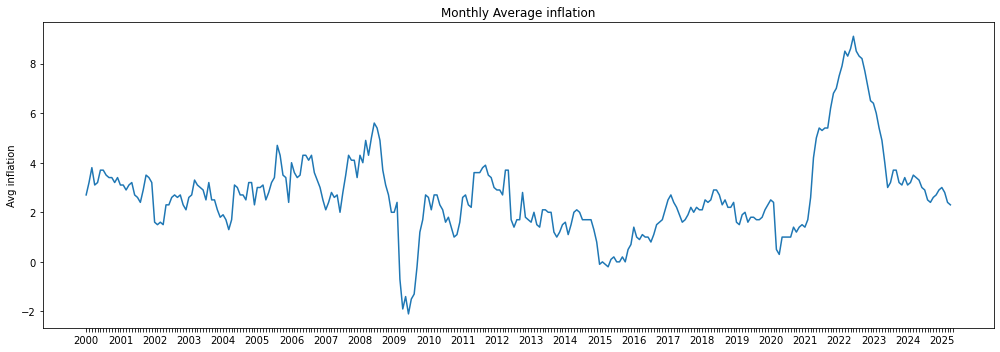

In [0]:
# Adding Year and Month columns
df_month = df_clean.withColumn("Year", year("Date")).withColumn("Month", month("Date"))

# Columns to plot
columns = ["Price", "Open", "High", "Low","FutPrice", "FutOpen","inflation"]

import matplotlib.pyplot as plt

for column in columns:
    # Group by Year and Month, compute average for each column
    monthly_avg = (
        df_month.groupBy("Year", "Month")
        .agg(avg(col(column)).alias(f"Avg_{column}"))
        .orderBy("Year", "Month")
        .rdd
        .map(lambda row: (row["Year"], row["Month"], row[f"Avg_{column}"]))
        .collect()
    )

    years, months, avg_vals = zip(*monthly_avg)

    # Show year label only where month == 1 (January) so that we can identify where every year starts and ends
    xticks = [f"{year}" if month == 1 else "" for year, month in zip(years, months)]

    plt.figure(figsize=(14,5))
    plt.plot(avg_vals, linestyle='-')
    plt.xlabel('')  # Remove x-axis label
    plt.ylabel(f'Avg {column}')
    plt.title(f'Monthly Average {column}')
    plt.xticks(ticks=range(len(avg_vals)), labels=xticks, rotation=0)
    plt.tight_layout()
    plt.show()


## Checking for missing values

In [0]:

# Total rows
total_rows = df_clean.count()

# Data types as dictionary
types = dict(df_clean.dtypes)

# Separate numeric vs. non-numeric columns
numeric_cols = [c for c in df_clean.columns if types[c] in ['double', 'float']]
non_numeric_cols = [c for c in df_clean.columns if types[c] not in ['double', 'float']]

# Count nulls and NaNs for numeric columns
numeric_counts = [count(when(isnull(col(c)) | isnan(col(c)), c)).alias(c) for c in numeric_cols]

# Count nulls only for non-numeric columns
non_numeric_counts = [count(when(isnull(col(c)), c)).alias(c) for c in non_numeric_cols]

# Combine and compute percentages
null_counts = df_clean.select(numeric_counts + non_numeric_counts).collect()[0].asDict()
missing_percent = {k: f"{(v / total_rows) * 100:.2f}%" for k, v in null_counts.items()}

# Display result
print("Missing value percentages per column:")
for col_name, pct in missing_percent.items():
    print(f"{col_name}: {pct}")


Missing value percentages per column:
Price: 0.00%
Open: 0.00%
High: 0.00%
Low: 0.00%
Volume: 100.00%
Change_Pct: 0.00%
FutPrice: 0.00%
FutOpen: 0.00%
inflation: 0.49%
Date: 0.00%


In [0]:
# Since "Volume" has 100% missing values we decided to drop the column
df_clean = df_clean.drop("Volume")


In [0]:
window_spec = Window.orderBy(F.col("Date").asc()).rowsBetween(Window.unboundedPreceding, 0)

df_clean = df_clean.withColumn(
    "inflation",
    F.first(F.col("inflation"), ignorenulls=True).over(window_spec)
)


In [0]:
# Total rows
total_rows = df_clean.count()

# Data types as dictionary
types = dict(df_clean.dtypes)

# Separate numeric vs. non-numeric columns
numeric_cols = [c for c in df_clean.columns if types[c] in ['double', 'float']]
non_numeric_cols = [c for c in df_clean.columns if types[c] not in ['double', 'float']]

# Count nulls and NaNs for numeric columns
numeric_counts = [count(when(isnull(col(c)) | isnan(col(c)), c)).alias(c) for c in numeric_cols]

# Count nulls only for non-numeric columns
non_numeric_counts = [count(when(isnull(col(c)), c)).alias(c) for c in non_numeric_cols]

# Combine and compute percentages
null_counts = df_clean.select(numeric_counts + non_numeric_counts).collect()[0].asDict()
missing_percent = {k: f"{(v / total_rows) * 100:.2f}%" for k, v in null_counts.items()}

# Display result
print("Missing value percentages per column:")
for col_name, pct in missing_percent.items():
    print(f"{col_name}: {pct}")

Missing value percentages per column:
Price: 0.00%
Open: 0.00%
High: 0.00%
Low: 0.00%
Change_Pct: 0.00%
FutPrice: 0.00%
FutOpen: 0.00%
inflation: 0.00%
Date: 0.00%


# Feature Engineering


In this step, we prepared the data for modeling by creating new features and defining our prediction target.

- **Sorting by Date**: The dataset was ordered chronologically to ensure that lag features reflect the correct time order.
  
- **Lag Features**: We generated lagged versions of key variables (`Price`, `Open`, `High`, `Low`, `Change_Pct`, `FutOpen`,`FutPrice`,`inflation`) using Spark's window functions. These features capture information from the previous day and help the model recognize temporal patterns.

- **Target Variable (`label`)**: A binary column was created to indicate whether the stock price increased the next day. It is defined as:
  - `1` if `Change_Pct > 0` (price went up)
  - `0` otherwise (price went down or stayed the same)

- **Handling Nulls**: The first row(s) resulting from the lag operations contain `null` values and were removed using `dropna()` to ensure clean training data.

The result is a new DataFrame (`df_model`) with both predictive features and the target variable ready for machine learning model training.


In [0]:
df_clean = df_clean.orderBy("Date")

In [0]:
# Define the window by date
window_spec = Window.orderBy("Date")

# Create lag features
df_lagged = df_clean \
    .withColumn("Lag_Price", lag("Price", 1).over(window_spec)) \
    .withColumn("Lag_Open", lag("Open", 1).over(window_spec)) \
    .withColumn("Lag_High", lag("High", 1).over(window_spec)) \
    .withColumn("Lag_Low", lag("Low", 1).over(window_spec)) \
    .withColumn("Lag_Change", lag("Change_Pct", 1).over(window_spec)) \
    .withColumn("Lag_FutOpen", lag("FutOpen", 1).over(window_spec)) \
    .withColumn("Lag_FutPrice", lag("FutPrice", 1).over(window_spec)) \
    .withColumn("Lag_inflation", lag("inflation", 1).over(window_spec))
    

In [0]:
# Create binary label based on Change_Pct
df_lagged = df_lagged.withColumn(
    "label", when(col("Change_Pct") > 0, 1).otherwise(0)
)

In [0]:
# Drop the nulls (from lag rows)
df_model = df_lagged.dropna()

In [0]:
# Quick sanity check
df_model.select("Date", "label", "Price", "Lag_Price", "Lag_Open", "Lag_Change", "Lag_inflation", "Lag_FutPrice", "Lag_FutOpen", "label").show(5)

+----------+-----+------+---------+--------+----------+-------------+------------+-----------+-----+
|      Date|label| Price|Lag_Price|Lag_Open|Lag_Change|Lag_inflation|Lag_FutPrice|Lag_FutOpen|label|
+----------+-----+------+---------+--------+----------+-------------+------------+-----------+-----+
|2000-01-04|    0|1399.4|   1455.2|  1469.2|     -0.95|          2.7|     1466.75|     1489.0|    0|
|2000-01-05|    1|1402.1|   1399.4|  1455.2|     -3.83|          2.7|     1411.75|     1467.0|    1|
|2000-01-06|    1|1403.5|   1402.1|  1399.4|      0.19|          2.7|      1413.5|     1411.5|    1|
|2000-01-07|    1|1441.5|   1403.5|  1402.1|       0.1|          2.7|      1404.0|     1411.0|    1|
|2000-01-10|    1|1457.6|   1441.5|  1403.5|      2.71|          2.7|      1460.5|    1403.75|    1|
+----------+-----+------+---------+--------+----------+-------------+------------+-----------+-----+
only showing top 5 rows



In [0]:
# List of features to use for modeling
feature_cols = ["Lag_Price", "Lag_Open", "Lag_High", "Lag_Low", "Lag_Change", "Lag_inflation", "Lag_FutPrice", "Lag_FutOpen"]

# Assemble into a single features column
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
df_final = assembler.transform(df_model)


In [0]:
# Split the data into train-test
train_data, test_data = df_final.randomSplit([0.8, 0.2], seed=42)

# Modeling

## Logistic Regression


We trained a logistic regression model to predict whether the stock price would increase the next day. The model used lag-based features derived from historical price metrics.

- **ROC AUC Score**: 0.5140 (close to random guessing, indicating low predictive power)
- **Confusion Matrix**: Helps visualize the number of correct vs. incorrect predictions for each class

Despite being simple and interpretable, the logistic regression model underperformed, suggesting the underlying pattern is non-linear or requires more complex features.


In [0]:
lr = LogisticRegression(featuresCol="features", labelCol="label")
lr_model = lr.fit(train_data)


In [0]:
# Predict on test data
predictions = lr_model.transform(test_data)

# Evaluate accuracy
evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
roc_auc = evaluator.evaluate(predictions)

print(f"ROC AUC on test set: {roc_auc:.4f}")

ROC AUC on test set: 0.5140


In [0]:
# Confusion matrix
predictions.groupBy("label", "prediction").count().show()

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    1|       0.0|   55|
|    0|       1.0|  516|
|    1|       1.0|  593|
|    0|       0.0|   55|
+-----+----------+-----+



In [0]:
display(predictions.groupBy("label", "prediction").count())

label,prediction,count
1,0.0,55
0,1.0,516
1,1.0,593
0,0.0,55


## Random Forest

We trained a Random Forest classifier using Spark MLlib to capture non-linear relationships between lagged price features and next-day market direction. The model was evaluated using ROC AUC and confusion matrix.

#### Steps:
- **Baseline Random Forest**: Trained with default parameters (`numTrees=100`)
- **Feature Importance**: Identified `Lag_Change` as the most influential feature.
- **Hyperparameter Tuning**: Used 3-fold cross-validation to search over `numTrees` and `maxDepth`.
- **Evaluation Metric**: ROC AUC was used to assess performance across all models.

#### Results:
| Model                     | ROC AUC |
|--------------------------|---------|
| Logistic Regression       | 0.5140  |
| Random Forest (untuned)   | 0.5206  |
| Random Forest (tuned)     | 0.5206  |

While all models performed slightly above random, the Random Forest (tuned) performed best. However, performance indicates potential data limitations or the need for richer feature engineering.


In [0]:
# Train the Random Forest
rf = RandomForestClassifier(featuresCol="features", labelCol="label", numTrees=100)
rf_model = rf.fit(train_data)


In [0]:
# Make predictions
rf_predictions = rf_model.transform(test_data)

# Evaluate with ROC AUC
rf_auc = evaluator.evaluate(rf_predictions)
print(f"Random Forest ROC AUC: {rf_auc:.4f}")

Random Forest ROC AUC: 0.5206


In [0]:
# Print feature importances
for feature, importance in zip(feature_cols, rf_model.featureImportances):
    print(f"{feature}: {importance:.4f}")


Lag_Price: 0.1027
Lag_Open: 0.0906
Lag_High: 0.1250
Lag_Low: 0.0948
Lag_Change: 0.4087
Lag_inflation: 0.0000
Lag_FutPrice: 0.0832
Lag_FutOpen: 0.0949


In [0]:
# Confusion matrix
rf_predictions.groupBy("label", "prediction").count().show()


+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    1|       1.0|  544|
|    0|       1.0|  466|
|    1|       0.0|  104|
|    0|       0.0|  105|
+-----+----------+-----+



In [0]:
display(rf_predictions.groupBy("label", "prediction").count())

label,prediction,count
1,1.0,544
0,1.0,466
1,0.0,104
0,0.0,105


In [0]:
# Reuse evaluator from before
evaluator = BinaryClassificationEvaluator(labelCol="label", metricName="areaUnderROC")

# Param grid for Random Forest
param_grid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [50, 100]) \
    .addGrid(rf.maxDepth, [5, 10]) \
    .build()

# CrossValidator setup
cv = CrossValidator(estimator=rf,
                    estimatorParamMaps=param_grid,
                    evaluator=evaluator,
                    numFolds=3)

# Train model using CV
cv_model = cv.fit(train_data)

# Predict and evaluate
cv_predictions = cv_model.transform(test_data)
cv_auc = evaluator.evaluate(cv_predictions)
print(f"Tuned Random Forest ROC AUC: {cv_auc:.4f}")


Tuned Random Forest ROC AUC: 0.5206


In [0]:
# UDF to extract probability of class 1 from DenseVector
def extract_prob(v):
    return float(v[1])

extract_prob_udf = udf(extract_prob, DoubleType())

# Apply UDF and create probability bucket
cv_buckets = cv_predictions.select(
    col("label").alias("Label"),
    extract_prob_udf(col("probability")).alias("Predicted_Probability")
).withColumn("bucket", floor(col("Predicted_Probability") * 10) / 10)

# Count by bucket and label
cv_bucket_stats = cv_buckets.groupBy("bucket", "Label").count().orderBy("bucket")

# Visualize
display(cv_bucket_stats)


bucket,Label,count
0.3,0,1
0.4,0,104
0.4,1,104
0.5,0,462
0.5,1,541
0.6,0,4
0.6,1,3


In [0]:
print(f"Logistic Regression ROC AUC: {roc_auc:.4f}")
print(f"Random Forest (untuned) ROC AUC: {rf_auc:.4f}")
print(f"Tuned Random Forest ROC AUC: {cv_auc:.4f}")


Logistic Regression ROC AUC: 0.5140
Random Forest (untuned) ROC AUC: 0.5206
Tuned Random Forest ROC AUC: 0.5206


# Conclusion

This project explored the use of Big Data tools for stock market direction prediction using Apache Spark MLlib.

We built a scalable pipeline that included:
- Efficient **data loading and cleaning** of historical S&P 500 prices
- **Feature engineering** with lag variables to capture temporal dependencies
- **Binary classification models** to predict whether the stock price would rise the next day

Three models were compared:
- **Logistic Regression** (baseline)
- **Random Forest** (untuned)
- **Random Forest with cross-validation and hyperparameter tuning**

All models were evaluated using **ROC AUC**, and visualized through:
- **Confusion matrices**
- **Probability bucket plots** to approximate ROC behavior (Databricks-native)

### Key Findings:
- **Model performance was modest**, with ROC AUC scores around 0.51–0.53
- **Lagged daily percentage change (Lag_Change)** was consistently the most important feature
- Even with tuning, predicting short-term market direction remains a challenging task with price data alone

### Future Directions:
To improve results, future work could incorporate:
- **Macroeconomic indicators** (CPI, etc.)
- **Sentiment analysis** from news or social media
- **Technical indicators** like moving averages or RSI
- **Streaming pipelines** to test the model in near real-time

This project demonstrates the power of Apache Spark for end-to-end machine learning workflows and reinforces the value of thoughtful data engineering and model evaluation when working with real-world time series problems.
